# Convert Data to TF Records
The data is currently expressed as SMILES strings in a CSV file. 
We need to convert them to graph representations for easier use with TF.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from molgym.utils.conversions import convert_smiles_to_nx
from molgym.mpnn.data import make_type_lookup_tables, convert_nx_to_dict, make_tfrecord
import tensorflow as tf
import pandas as pd
import numpy as np
import json

## Load in the IC50 Data
Provided by Neeraj Kumar

In [2]:
data = pd.read_csv('protease_only_id_smiles_IC50.csv')

## Parse the SMILES strings to NX graphs
This is our standard form for working with molecular graphs

In [3]:
data['nx'] = data['InChI'].apply(convert_smiles_to_nx)

## Convert the Objects to Dictionaries
These dictionaries will mimic the structure of the TFRecords.
We first compute a lookup table to match atom types with an integer index, 
which we will use when creating molecules

In [4]:
atom_types, bond_types = make_type_lookup_tables(data['nx'].tolist())

In [5]:
with open('atom_types.json', 'w') as fp:
    json.dump(atom_types, fp)

In [6]:
with open('bond_types.json', 'w') as fp:
    json.dump(bond_types, fp)

In [7]:
data['dict'] = data['nx'].apply(lambda x: convert_nx_to_dict(x, atom_types, bond_types))

## Clean the IC50 Values
A few of our IC50 files are not floats. They are just listed as being above or below a range. For simplicity, we will assume a value of the provided threshold for each

In [8]:
data['IC50_cleaned'] = data['IC50'].apply(lambda x: float(x.strip(' ><')))

In [9]:
data['pIC50'] = -1 * np.log10(data['IC50_cleaned'] * 1e9)

Text(0, 0.5, 'Frequency')

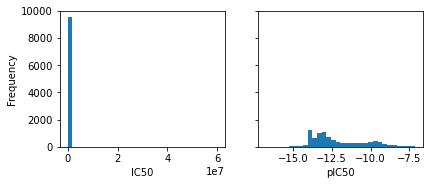

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[0].hist(data['IC50_cleaned'], bins=32)
axs[0].set_xlabel('IC50')
axs[1].hist(data['pIC50'], bins=32)
axs[1].set_xlabel('pIC50')

axs[0].set_ylabel('Frequency')

Given the huge range of values, we are going to use the log value as output for the model

## Save as a TF Record File
We need to add the IC50 to the record, then save it to disk

In [11]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=1)
print(f'Split off {len(test_data)} mols for testing')

Split off 956 mols for testing


In [12]:
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=2)
print(f'Split remaining mols into a {len(train_data)}/{len(val_data)} split for train and validation')

Split remaining mols into a 7736/860 split for train and validation


In [13]:
for path, data in zip(['train_data.proto', 'val_data.proto', 'test_data.proto'], 
                     [train_data, val_data, test_data]):
    with tf.io.TFRecordWriter(path) as writer:
        for _, entry in data.iterrows():
            record = entry['dict']
            record['pIC50'] = entry['pIC50']
            writer.write(make_tfrecord(record))